York Solutions | AML BB Cohort 2023-2024
Final Capstone Project - Customer Propensity

This assignment is to design, build, evaluate, and deploy a Machine Learning model to predict customer propensity to perform the "Add to Cart" action. The model should accurately predict whether this action will be performed or not based on the features selected or developed from the given dataset. This model is essential as part of the Q2 business goal to increase the return on ad-spending of the company employing google analytics. 

Using google analytics 360 sample dataset on BigQuery, develop, and deploy a model in VertexAI to predict when a 'hit' will have an event action of "Add to Cart". To start with, a 1-month period of my choice should be used to train the model, with the goal of being able to easily substitute in the 12-month period (full dataset) after validating the model. Because of the dataset size, it is assumed that data cleaning and feature selection will take place to test and train the modle in a timely manner. 



scikit package, seaborn, numpy? Are there any terminal installation and commands-required?


In [72]:
## Allowed dependencies for this project that could still be included:
## SciPy
## Google-cloud-*

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel


import warnings # suppressing warnings that keep taking up space during my code executions



Data Exploration and Pre-Processing:

1. Load the dataset from BigQuery into this Jupyter Notebook | Vertex AI | Python Environment (1-month worth of data)  -- DONE
2. Handle Missing Values, outliers, and any data quality issues  -- DONE
3. Perform Exploratory Data Analysis to understand the structure, distribution, and characteristics of the data
4. Convert categorical variables into numerical representations if needed (e.g., one-hot encoding)
5. Split the data into training and test sets


In [2]:
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

BQ_LOCATION = 'US'
REGION = 'us-east-1'

In [3]:
%%bigquery selectData_bq_df --project $PROJECT_ID
SELECT 
concat(fullVisitorId, visitId) AS session_id,
visitNumber, CAST(SUBSTRING(`date`,5,2) AS int) AS month,
CAST(SUBSTRING(`date`,7,2) AS int) AS day_of_month,
totals.hits,
hit.hitNumber,
CASE WHEN totals.visits IS NULL THEN 0 ELSE 1 END AS visits,
CASE WHEN totals.bounces IS NULL THEN 0 ELSE 1 END AS bounces, 
CASE WHEN trafficSource.isTrueDirect IS NULL THEN 0 WHEN trafficSource.isTrueDirect IS FALSE THEN 0 ELSE 1 END AS isTrueDirect,
trafficSource.medium,
trafficSource.source,
CASE socialEngagementType WHEN 'Not Socially Engaged' THEN 0 ELSE 1 END AS social_Engagement,
channelGrouping,
device.deviceCategory,
promo.promoName,
CASE WHEN hit.promotionActionInfo.promoIsView IS NULL THEN 0 ELSE 1 END AS promoIsView,
CASE hit.eCommerceAction.action_type WHEN '3' THEN 1 ELSE 0 END AS add_to_cart
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  LEFT JOIN UNNEST (hits) AS hit
  LEFT JOIN UNNEST (hit.promotion) AS promo
WHERE 
  _TABLE_SUFFIX BETWEEN '20161120' AND '20161220'
ORDER BY session_id, hit.hitNumber


Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
#Pivoting the PromoName to create new promoColumns, filled with 1s and 0s

# Mapping from promoName to new column names

promo_mapping = {
    "Office": "promoOffice",
    "Leatherette Journal": "promoLeather",
    "Electronics Accessory Pouch": "promoElectro",
    "Mens T-Shirts": "promoMtshirts",
    "Fruit Games": "promoFruit",
    "Andriod Brand": "promoAndroid",
    "Drinkware": "promoDrinks",
    "Office Campaign": "promoOfficeCampaign",
    "Pen Pencil & Highlighter Set": "promoPenPencilHigh",
    "Lifestyle Campaign": "promoLifestyle",
    "Accessories Campaign": "promoAccessories",
    "Engraved Ceramic Google Mug": "promoEngravedCeramic",
    "Backpacks": "promoBack",
    "Womens T-Shirts": "promoWtshirts",
    "Google Brand": "promoGoogle",
    "YouTube Brand": "promoYoutube",
    "Apparel": "promoApparel",
    "Apparel Campaign": "promoApparelCampaign"
}


# Loop through the promo_mapping and create new columns, taking into account None values
for promo_name, new_column_name in promo_mapping.items():
    selectData_bq_df[new_column_name] = selectData_bq_df['promoName'].apply(lambda x: 1 if x is not None and promo_name in x else 0)

    
# Drop the original promoName column
selectData_bq_df.drop(columns=['promoName'], inplace=True)


# If you want to fill NaN values with 0 in the new columns
selectData_bq_df.fillna(0, inplace=True)

In [5]:
## Display the first 10 rows of the Dataframe to inspect the data, confirm appropriate structure to dataset transfer:

print(selectData_bq_df.head(10))

                      session_id  visitNumber  month  day_of_month  hits  \
0  00000204243422487471480578901            1     11            30    17   
1  00000204243422487471480578901            1     11            30    17   
2  00000204243422487471480578901            1     11            30    17   
3  00000204243422487471480578901            1     11            30    17   
4  00000204243422487471480578901            1     11            30    17   
5  00000204243422487471480578901            1     11            30    17   
6  00000204243422487471480578901            1     11            30    17   
7  00000204243422487471480578901            1     11            30    17   
8  00000204243422487471480578901            1     11            30    17   
9  00000204243422487471480578901            1     11            30    17   

   hitNumber  visits  bounces  isTrueDirect  medium  ... promoPenPencilHigh  \
0          1       1        0             0  (none)  ...                  0   
1    

In [6]:
## DataFrame Column Data Types

selectData_bq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128153 entries, 0 to 1128152
Data columns (total 34 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   session_id            1128153 non-null  object
 1   visitNumber           1128153 non-null  Int64 
 2   month                 1128153 non-null  Int64 
 3   day_of_month          1128153 non-null  Int64 
 4   hits                  1128153 non-null  Int64 
 5   hitNumber             1128153 non-null  Int64 
 6   visits                1128153 non-null  Int64 
 7   bounces               1128153 non-null  Int64 
 8   isTrueDirect          1128153 non-null  Int64 
 9   medium                1128153 non-null  object
 10  source                1128153 non-null  object
 11  social_Engagement     1128153 non-null  Int64 
 12  channelGrouping       1128153 non-null  object
 13  deviceCategory        1128153 non-null  object
 14  promoIsView           1128153 non-null  Int64 
 15

In [7]:
## Print out the first and last five rows to better visualize the data

print(selectData_bq_df)

                            session_id  visitNumber  month  day_of_month  \
0        00000204243422487471480578901            1     11            30   
1        00000204243422487471480578901            1     11            30   
2        00000204243422487471480578901            1     11            30   
3        00000204243422487471480578901            1     11            30   
4        00000204243422487471480578901            1     11            30   
...                                ...          ...    ...           ...   
1128148  99998874200163075701480139386            1     11            25   
1128149  99998874200163075701480139386            1     11            25   
1128150  99998874200163075701480139386            1     11            25   
1128151  99998874200163075701480139386            1     11            25   
1128152  99998874200163075701480139386            1     11            25   

         hits  hitNumber  visits  bounces  isTrueDirect  medium  ...  \
0          17  

In [8]:
## Summary Statistics for numerical fields in out DataFrame

selectData_bq_df.describe()

,visitNumber,month,day_of_month,hits,hitNumber,visits,bounces,isTrueDirect,social_Engagement,promoIsView,...,promoPenPencilHigh,promoLifestyle,promoAccessories,promoEngravedCeramic,promoBack,promoWtshirts,promoGoogle,promoYoutube,promoApparel,promoApparelCampaign
count,1128153.0,1128153.0,1128153.0,1128153.0,1128153.0,1128153.0,1128153.0,1128153.0,1128153.0,1128153.0,...,1128153.0,1128153.0,1128153.0,1128153.0,1.128153e+06,1.128153e+06,1.128153e+06,1.128153e+06,1.128153e+06,1128153.0
mean,2.60915,11.621219,15.778646,15.724808,7.465763,1.0,0.089061,0.340683,0.0,0.652316,...,0.0,0.0,0.0,0.0,7.355119e-02,7.302733e-02,7.404935e-02,7.400592e-02,7.397312e-02,0.0
std,10.243455,0.485084,8.93807,24.377132,14.397759,0.0,0.284831,0.473939,0.0,0.476235,...,0.0,0.0,0.0,0.0,2.610392e-01,2.601815e-01,2.618513e-01,2.617806e-01,2.617273e-01,0.0
min,1.0,11.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.0,11.0,8.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,1.0,12.0,16.0,7.0,2.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
75%,2.0,12.0,23.0,18.0,7.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
max,286.0,12.0,30.0,286.0,286.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0


In [9]:
## Check for Missing Values

selectData_bq_df.isnull().sum()


session_id              0
visitNumber             0
month                   0
day_of_month            0
hits                    0
hitNumber               0
visits                  0
bounces                 0
isTrueDirect            0
medium                  0
source                  0
social_Engagement       0
channelGrouping         0
deviceCategory          0
promoIsView             0
add_to_cart             0
promoOffice             0
promoLeather            0
promoElectro            0
promoMtshirts           0
promoFruit              0
promoAndroid            0
promoDrinks             0
promoOfficeCampaign     0
promoPenPencilHigh      0
promoLifestyle          0
promoAccessories        0
promoEngravedCeramic    0
promoBack               0
promoWtshirts           0
promoGoogle             0
promoYoutube            0
promoApparel            0
promoApparelCampaign    0
dtype: int64

In [10]:
# Handle Missing Values: 
    ## None Exist from Data Structuring and Modifications

## Fill missing values: 
    ## Not Applicable, no missing values. 

In [11]:
# Create Categorical & Numerical Columns:

categorical_columns = selectData_bq_df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = selectData_bq_df.select_dtypes(include=['Int64','int64']).columns.tolist()

In [12]:
# Create new DataFrames for to run EDA analysis:
categorical_df = selectData_bq_df[categorical_columns]
numerical_df = selectData_bq_df[numerical_columns]   

In [14]:
# Suppress FutureWarnings related to use_inf_as_na option
warnings.simplefilter(action='ignore', category=FutureWarning)

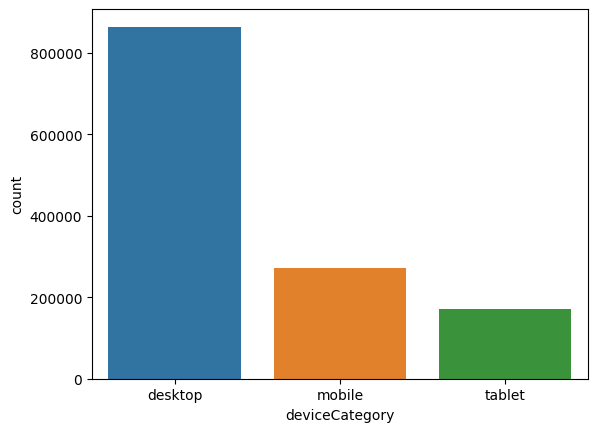

In [22]:
# Rudumentary EDA:

# Countplots for Categorical Columns:
for column in categorical_df.columns:
    sns.countplot(data=categorical_df, x=column)
    
# this will display countplots for each categorical column in the dataset

In [ ]:
# Rudumentary EDA:

# Barplot for Categorical Columns:
for column in categorical_df.columns:
    sns.barplot(data=categorical_df, x=column, y=categorical_df.index)

# this will help visualize the count of each category in a categorical variable

Pipeline Pre-Processing & Feature Selection / Engineering:

1. Select relevant features that might influence the "Add to Cart" action
2. Perform Feature Engineering to create new features if necessary (e.g. combining or transforming existing features)
3. Use domain knowledge and insights gained from EDA to guide feature selection and engineering

In [25]:
# One-Hot Encoding - # Leave out session ID, because this doesn't actually have data to be inferred upon. It's an ID. 

# List of columns to encode:
columns_to_encode = ['medium', 'source', 'channelGrouping', 'deviceCategory']

# Perform one-hot encoding for each column
one_hot_encoded = pd.get_dummies(selectData_bq_df[columns_to_encode])


In [26]:
# Concatenate the one-hot encoded columns with the original DataFrame:
encoded_df = pd.concat([selectData_bq_df, one_hot_encoded], axis=1)

# Drop the original categorical columns, they serve no purpose now and will not be used in the models
encoded_df.drop(columns = columns_to_encode, inplace=True)


In [28]:
# Get list of all column names after one-hot encoding
encoded_column_names = encoded_df.columns.tolist()

# Display the list of encoded column names
print(encoded_column_names)

['session_id', 'visitNumber', 'month', 'day_of_month', 'hits', 'hitNumber', 'visits', 'bounces', 'isTrueDirect', 'social_Engagement', 'promoIsView', 'add_to_cart', 'promoOffice', 'promoLeather', 'promoElectro', 'promoMtshirts', 'promoFruit', 'promoAndroid', 'promoDrinks', 'promoOfficeCampaign', 'promoPenPencilHigh', 'promoLifestyle', 'promoAccessories', 'promoEngravedCeramic', 'promoBack', 'promoWtshirts', 'promoGoogle', 'promoYoutube', 'promoApparel', 'promoApparelCampaign', 'medium_(none)', 'medium_affiliate', 'medium_cpm', 'medium_organic', 'medium_referral', 'source_(direct)', 'source_Partners', 'source_ad.doubleclick.net', 'source_adwords.google.com', 'source_amazon.com', 'source_analytics.google.com', 'source_aol', 'source_arstechnica.com', 'source_ask', 'source_au.search.yahoo.com', 'source_baidu', 'source_bing', 'source_blog.golang.org', 'source_ca.search.yahoo.com', 'source_col128.mail.live.com', 'source_connect.googleforwork.com', 'source_course.fso.fullsail.edu', 'source_dai

In [29]:
# Min-Max Scaling - Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Extract the features to be scaled (exclude non-numerics which is session id, typically a randomly assigned integer that has no inherent value)
features_to_scale = encoded_df = encoded_df.drop(columns=['session_id'])

In [30]:
# Fit the scaler to the features and transform the data
scaled_features = scaler.fit_transform(features_to_scale)

In [31]:
# Convert the scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# Display the scaled features 
print(scaled_df)

         visitNumber  month  day_of_month      hits  hitNumber  visits  \
0                0.0    0.0      1.000000  0.056140   0.000000     0.0   
1                0.0    0.0      1.000000  0.056140   0.003509     0.0   
2                0.0    0.0      1.000000  0.056140   0.003509     0.0   
3                0.0    0.0      1.000000  0.056140   0.003509     0.0   
4                0.0    0.0      1.000000  0.056140   0.003509     0.0   
...              ...    ...           ...       ...        ...     ...   
1128148          0.0    0.0      0.827586  0.021053   0.007018     0.0   
1128149          0.0    0.0      0.827586  0.021053   0.010526     0.0   
1128150          0.0    0.0      0.827586  0.021053   0.014035     0.0   
1128151          0.0    0.0      0.827586  0.021053   0.017544     0.0   
1128152          0.0    0.0      0.827586  0.021053   0.021053     0.0   

         bounces  isTrueDirect  social_Engagement  promoIsView  ...  \
0            0.0           0.0          

In [35]:
## Feature Selection -- DO NOT SELECT ALL, OTHERWISE IT'S OVERFITTING

selected_features = [
    #From the Original Data Featues
    'hits', 'hitNumber', 'isTrueDirect', 'social_Engagement', 
    'promoIsView', 'promoOffice','promoLeather','promoElectro','promoMtshirts', 'promoFruit', 
    'promoAndroid', 'promoDrinks', 'promoOfficeCampaign', 'promoPenPencilHigh', 'promoLifestyle', 
    'promoAccessories', 'promoEngravedCeramic', 'promoBack', 'promoWtshirts', 'promoGoogle', 'promoYoutube', 
    'promoApparel', 'promoApparelCampaign',
    
    #Adding the One-Hot Encoding Features
    'medium_(none)', 'medium_affiliate', 'medium_cpm', 'medium_organic', 'medium_referral', 'source_(direct)', 'channelGrouping_Affiliates', 
    'channelGrouping_Direct', 'channelGrouping_Display', 'channelGrouping_Organic Search', 'channelGrouping_Paid Search', 'channelGrouping_Referral', 
    'channelGrouping_Social', 'deviceCategory_desktop', 'deviceCategory_mobile', 'deviceCategory_tablet'

]

Model Selection and Training:

1. Choose appropriate machine learning models for binary classification (e.g. Logistic Regression, Random Forest, GB)
2. Train different models on the training dataset
3. Evaluate models using appropriate evaluation metrics (e.g. accuracy precision, recall, F1-score)
4. Optimize hyperparameters using techniques like grid search or random search


In [36]:
## Split the Data into features (X) and Target Variable (y)
X = scaled_df[selected_features]
y = scaled_df['add_to_cart']     # the target is the eCommerce action_type "Add to Cart"

In [37]:
## Split the data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=72)

Model Evaluation and Tuning: 

1. Evaluate the trained models on the testing dataset
2. Analyze model performance using evaluation metrics and confusion matrices
3. Fine-tune the models based on the evaluation results
4. Iterate on feature selection, engineering, and model training if necessary


In [39]:
# Logistic Regression Model - Initializing

log_reg_model = LogisticRegression()


In [40]:
# Fit the logistic regression model to the training data "Train the Model"

log_reg_model.fit(X_train, y_train)


LogisticRegression()

In [41]:
# Now that the model is trained, make predictions

y_pred = log_reg_model.predict(X_test)


In [42]:
# Evaluate the model, calculate accuracy:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9889093352337798


In [43]:
# Generate classification report:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    278921
         1.0       0.27      0.00      0.00      3118

    accuracy                           0.99    282039
   macro avg       0.63      0.50      0.50    282039
weighted avg       0.98      0.99      0.98    282039



In [44]:
# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[278905     16]
 [  3112      6]]


In [48]:
# Hyperparameter tuning for the Logistic Regression Model
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty':['l2']}


In [49]:
# Perform grid search cross-validation
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
             scoring='accuracy')

In [51]:
# Get best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 0.01, 'penalty': 'l2'}


In [52]:
# Now, need to re-train the model with the best hyperparams
best_log_reg_model = LogisticRegression(**best_params)
best_log_reg_model.fit(X_train, y_train)

LogisticRegression(C=0.01)

In [53]:
# Make predictions on the newly tuned model
y_pred_tuned = best_log_reg_model.predict(X_test)

In [54]:
# Evaluate the tuned model
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print("Tuned Log Reg Model Accuracy", tuned_accuracy)

Tuned Log Reg Model Accuracy 0.9889447913231858


In [56]:
# Compute the F1-score:
f1 = f1_score(y_test, y_pred_tuned)

In [59]:
# Print F1 score
print("F1-score:", f1)  

# Got the worst score possible, meaning either precision or recall are zero. 
# This could be happen from Imbalanced Dataset, Model Bias or Underfiting, Data Quality Issues, or Incorrect Model Selection, this is why we have
# to continue trying other models and iterating through different features selections. 

F1-score: 0.0


In [ ]:
# Attempting a separate model - Random Forest

In [62]:
# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=72)


In [63]:
# Train the classifier on the training data, "Fit it to the model about to be used"
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=72)

In [64]:
# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)

In [67]:
# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

In [68]:
# Print the evaluation metrics
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_rf)
print("F1-score:", f1_rf)

Random Forest Model Evaluation:
Accuracy: 0.9870833466293668
F1-score: 0.029826897470039946


Yet again, another model that performs poorly. Too high an accuracy with a poor f1-score. I am limited in my approach towards tackling this assignment. Without being able to consult with domain experts, that is to say professionally-seasoned data analysts, I feel like I'm striking a sturdy metal object with a rubber mallet. Will continue to look at other avenues. 

Failure is sometimes a part of the learning process. Often the one that leads to the most insights. 

In hindsight, the data selection process could have been the nail that hammered shut the coffin on this project. Too late to turn around now. Either that, or there is a some form in imbalance that is inherent in the data, but was never properly cleared. 

In [ ]:
# Naive Bayes Classifier 

In [73]:
# Initialize the Naive Bayes Classifier
nb_classifier = GaussianNB()

In [74]:
# Train the classifier on the Training Data
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [75]:
# Make predictions on the test data
y_pred_nb = nb_classifier.predict(X_test)

In [76]:
# Evaluate the model's performance:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Model Accuracy:", accuracy_nb)

Naive Bayes Model Accuracy: 0.6722049078318956


In [77]:
# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80    278921
         1.0       0.03      1.00      0.06      3118

    accuracy                           0.67    282039
   macro avg       0.52      0.83      0.43    282039
weighted avg       0.99      0.67      0.79    282039



In [78]:
# Generate Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))


Confusion Matrix:
[[186482  92439]
 [    12   3106]]


Deployment:

1. Deploy the trained model to Google Cloud Platform (GCP) using VertexAI or any other suitable service
2. Document the deployment process, including all necessary steps for redeployment.
3. Ensure the deployed model can respond to prediction requests efficiently

In [ ]:
## Placeholder